lstm2

과정 요약:<br> 
feature: season, day of week, week number, sales <br> 
feature engineering: normalize+ denormalize

결과요약: seed 7: rmse 96.04 (마지막 

상세과정:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 
이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

추가의견) 개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

추가의견2) 처음에는 denormalize과정 없이 rmse를 구했는데, 이것보다는 denormalize를 한 후 rmse를 구하여 모델간 비교를 하는 것이 더 적절한 것 같다. normalize는 어디까지나 변환이니 항상 변환을 할때는 역변환을 하여 원본 데이터 형태m로 생각하는 것이 덜 헷갈리고, 결과값에 대한 더욱 직관적인 이해가 가능할 것 같다. 그리고, 여러 형태의 data transformation이 있는데 normalize 가장 마지막 단계의 data transformation인 것 같다. 다른 로그나 루트 변환을 한 후 normalization을 하고, 그리고 예측값이 모델을 통해 생성되면 바로 denormalize하고...예측(뉴럴) 모델의 input직전과 output직후.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime   

set seednumber(7 or 77)

In [2]:
tf.set_random_seed(77)

# 1. DATA 준비

In [3]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [4]:
sales=list(txs['sales'])

In [5]:
sales

[34,
 41,
 54,
 41,
 35,
 44,
 50,
 42,
 42,
 66,
 50,
 55,
 56,
 53,
 44,
 54,
 54,
 50,
 40,
 49,
 28,
 72,
 71,
 53,
 43,
 38,
 55,
 49,
 43,
 49,
 49,
 44,
 39,
 52,
 45,
 33,
 43,
 40,
 46,
 49,
 50,
 37,
 37,
 45,
 48,
 48,
 38,
 60,
 31,
 35,
 53,
 70,
 62,
 48,
 51,
 49,
 38,
 32,
 39,
 35,
 30,
 36,
 31,
 31,
 44,
 41,
 41,
 45,
 46,
 45,
 41,
 47,
 48,
 40,
 42,
 38,
 38,
 45,
 48,
 62,
 46,
 38,
 62,
 81,
 40,
 45,
 42,
 53,
 53,
 56,
 53,
 47,
 61,
 64,
 62,
 37,
 65,
 54,
 44,
 46,
 50,
 43,
 53,
 63,
 52,
 2,
 0,
 0,
 72,
 59,
 75,
 47,
 44,
 77,
 90,
 93,
 47,
 61,
 77,
 282,
 50,
 58,
 33,
 41,
 36,
 64,
 49,
 53,
 60,
 43,
 41,
 55,
 45,
 18,
 60,
 69,
 54,
 39,
 50,
 44,
 54,
 57,
 82,
 57,
 44,
 56,
 51,
 55,
 28,
 56,
 54,
 36,
 12,
 25,
 41,
 11,
 6,
 9,
 230,
 29,
 24,
 23,
 14,
 21,
 20,
 25,
 23,
 27,
 31,
 16,
 14,
 30,
 32,
 75,
 35,
 26,
 12,
 21,
 23,
 28,
 25,
 31,
 21,
 17,
 10,
 29,
 34,
 28,
 20,
 36,
 23,
 15,
 42,
 28,
 24,
 29,
 20,
 14,
 18,
 27,
 22

## 1.1 기본 feature

'ds-y'의 ds로부터 api로 얻을 수 있는 값

year, day of week, month, week number를 기본 feature로 설정

In [6]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

In [7]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['day_of_week']=txs['date'].map(day_of_week)

## 1.2 추가 feature + 가공

'ds-y'의 ds로부터 api로 얻을 수 없는 값: 본 feature를 가공한 feature + ds와 무관한 feature

### X

계절

In [8]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

주중/주말(0,1)

In [9]:
day_of_week01s=[0,0,0,0,0,1,1]
day_of_week01= lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d" ).weekday())]

In [10]:
txs['season']=txs['date'].map(season)
txs['day_of_week01']=txs['date'].map(day_of_week01)
txs

,date,sales,year,month,week_number,day_of_week,season,day_of_week01
0,2016-01-01,34,2016,1,53,4,0,0
1,2016-01-02,41,2016,1,53,5,0,1
2,2016-01-03,54,2016,1,53,6,0,1
3,2016-01-04,41,2016,1,01,0,0,0
4,2016-01-05,35,2016,1,01,1,0,0
5,2016-01-06,44,2016,1,01,2,0,0
6,2016-01-07,50,2016,1,01,3,0,0
7,2016-01-08,42,2016,1,01,4,0,0
8,2016-01-09,42,2016,1,01,5,0,1
9,2016-01-10,66,2016,1,01,6,0,1


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

## 1.3 추가 가공

### 1.3.1 y의 추가 가공

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음(아무런 가공되지 않은 원본 sales)

In [11]:
originalSales=list(txs['sales'])
sales=list(txs['sales'])

In [12]:
282 in originalSales

True

가공을 하는 순서도 중요한데, 이상점 제거-> log or sqrt -> normalization이다. 

이상점 제거, bucketization 을 하여 새로운 열을 생성하는 방향으로

#### 이상점 제거

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

In [13]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales

#### log(y)

In [14]:
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)

#### sqrt(y)

In [15]:
def sqrtSales(sales):
    return np.sqrt(sales)

In [16]:
sales=noOutlierSales(sales)

In [17]:
282 in sales

False

In [18]:
282 in originalSales

True

### 1.3.2 x의 추가 가공

## 1.4 합친 후 (필요 시 normalize하여) 최종 data 생성: XY

계절(0~3) + 요일(0~6) + 주수(1~53) -> 판매량

In [19]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

계절(0~3) + 요일(0,1) + 주수(1~53) -> 판매량

In [20]:
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]

In [21]:
xy=np.array(tempxy).transpose().astype(np.float)
originalXY=np.array(tempxy).transpose().astype(np.float)

#### Normalization

In [22]:
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

Normalization이 필요한 열을 normalize시킴(현재는 sales에 해당하는 마지막 열만 normalize)

In [23]:
xy=minMaxNormalizer(xy)

In [24]:
xy

array([[ 0.  ,  0.04,  0.53,  0.34],
       [ 0.  ,  0.05,  0.53,  0.41],
       [ 0.  ,  0.06,  0.53,  0.54],
       ..., 
       [ 0.  ,  0.06,  0.04,  0.  ],
       [ 0.  ,  0.  ,  0.05,  0.05],
       [ 0.  ,  0.01,  0.05,  0.31]])

In [25]:
# xy[:,-1]=minMaxNormalizer(xy[:,-1])

다른 열 ex) XY[:,-3]=minMaxNormalizer(XY[:,-3])

#### Denormalization

예측모델을 통해 얻은 sales결과를 denormalize시켜 기존 단위로 변환

In [26]:
def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 

이 함수를 마지막 rmse구하기 전에 호출

# 2. MODEL 설계

## 2.1 사용 model 정의: RNN LSTM

## 2.2 해당 model의 train parameters 설정

In [27]:
#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=4

#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5

#output_dim(=forecastDays)만큼의 다음날 y_data를 예측
forecastDays=1
output_dim=forecastDays

#hidden_dim은 정말 임의로 설정
hidden_dim=10

#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01

#iterations는 반복 횟수
iterations=1000

## 2.3 사용 model, train parameter에 맞추어 dataset(XY) 변환: dataX, dataY

In [28]:
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    #     _y=Y[i+seq_length:i+seq_length+forecastDays]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

[[ 0.    0.04  0.53  0.34]
 [ 0.    0.05  0.53  0.41]
 [ 0.    0.06  0.53  0.54]
 [ 0.    0.    0.01  0.41]
 [ 0.    0.01  0.01  0.35]] -> [ 0.44]
[[ 0.    0.05  0.53  0.41]
 [ 0.    0.06  0.53  0.54]
 [ 0.    0.    0.01  0.41]
 [ 0.    0.01  0.01  0.35]
 [ 0.    0.02  0.01  0.44]] -> [ 0.5]
[[ 0.    0.06  0.53  0.54]
 [ 0.    0.    0.01  0.41]
 [ 0.    0.01  0.01  0.35]
 [ 0.    0.02  0.01  0.44]
 [ 0.    0.03  0.01  0.5 ]] -> [ 0.42]
[[ 0.    0.    0.01  0.41]
 [ 0.    0.01  0.01  0.35]
 [ 0.    0.02  0.01  0.44]
 [ 0.    0.03  0.01  0.5 ]
 [ 0.    0.04  0.01  0.42]] -> [ 0.42]
[[ 0.    0.01  0.01  0.35]
 [ 0.    0.02  0.01  0.44]
 [ 0.    0.03  0.01  0.5 ]
 [ 0.    0.04  0.01  0.42]
 [ 0.    0.05  0.01  0.42]] -> [ 0.66]
[[ 0.    0.02  0.01  0.44]
 [ 0.    0.03  0.01  0.5 ]
 [ 0.    0.04  0.01  0.42]
 [ 0.    0.05  0.01  0.42]
 [ 0.    0.06  0.01  0.66]] -> [ 0.5]
[[ 0.    0.03  0.01  0.5 ]
 [ 0.    0.04  0.01  0.42]
 [ 0.    0.05  0.01  0.42]
 [ 0.    0.06  0.01  0.66]
 [ 0.    0. 

## 2.4 train/test split

In [29]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

## 2.5 input place holders

X의 경우 input type과 [batch size, sequence length, input data dimension(feature+1))]

Y의 경우 input type과 [batch size, 원하는 output 의 개수(forecastDays)]

In [30]:
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDays])

## 2.6 build LSTM network model

lstm network의 

    기본단위 cell, 
    
    사용 driver, 
    
    예측 y 산출방식, 
    
    loss 함수, 
    
    사용 optimizer 정하기

### lstm의 한 기본단위인 cell을 생성

cell의 결과값을 fully connected layer로 한 번 더 가공할 것이기 때문에 cell의 output dimension인 num_units=hidden_dim로 설정

In [31]:
# cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

In [32]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.nn.relu)

### Dynamic rnn이라는 driver를 가동

tf.dynamic_rnn의 input은 cell, input, input type

tf.dynamic_rnn의 output은 outputs와 states

In [33]:
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### 마지막 cell의 output과 fully connected layer를  이용하여 Y_pred 도출

outputs[:, -1]: cell의 outputs 중 마지막 하나만 이용(we use the last cell's output)

output_dim: fully connected의 최종출력개수는 output_dim(=forecastDays) 

activation_fn= None: 분류 문제가 아니라 회귀 문제이므로 activation_fn은 none

In [34]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 

### loss 정의

In [35]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

### optimizer정의

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate)

### loss를 줄이는 방향으로 train

In [37]:
train = optimizer.minimize(loss)

# 3. Model 평가 with RMSE

In [38]:
denormalizedTestY=originalSales[train_size+seq_length:]
denormalizedTestY_preprocessed=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

In [39]:
121 in denormalizedTestY

True

In [40]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

In [41]:
def rootMeanSquaredError(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt( sum/len(a))

## 2.5 Train and Test

[step: 0] loss: 62.392765045166016
[step: 1] loss: 56.10784149169922
[step: 2] loss: 50.1355094909668
[step: 3] loss: 44.490623474121094
[step: 4] loss: 39.371864318847656
[step: 5] loss: 34.81439208984375
[step: 6] loss: 30.532859802246094
[step: 7] loss: 26.204259872436523
[step: 8] loss: 21.963151931762695
[step: 9] loss: 18.01466178894043
[step: 10] loss: 14.554482460021973
[step: 11] loss: 11.874048233032227
[step: 12] loss: 10.343114852905273
[step: 13] loss: 10.189848899841309
[step: 14] loss: 11.071829795837402
[step: 15] loss: 12.152756690979004
[step: 16] loss: 12.701696395874023
[step: 17] loss: 12.484926223754883
[step: 18] loss: 11.683600425720215
[step: 19] loss: 10.626652717590332
[step: 20] loss: 9.600470542907715
[step: 21] loss: 8.77655029296875
[step: 22] loss: 8.210589408874512
[step: 23] loss: 7.880557537078857
[step: 24] loss: 7.727231502532959
[step: 25] loss: 7.6828508377075195
[step: 26] loss: 7.687564373016357
[step: 27] loss: 7.695969581604004
[step: 28] loss

[step: 244] loss: 4.762340068817139
[step: 245] loss: 4.761842727661133
[step: 246] loss: 4.761348247528076
[step: 247] loss: 4.760851860046387
[step: 248] loss: 4.760356426239014
[step: 249] loss: 4.759864330291748
[step: 250] loss: 4.759373664855957
[step: 251] loss: 4.758882522583008
[step: 252] loss: 4.758389949798584
[step: 253] loss: 4.757896900177002
[step: 254] loss: 4.757405757904053
[step: 255] loss: 4.756916046142578
[step: 256] loss: 4.7564263343811035
[step: 257] loss: 4.7559380531311035
[step: 258] loss: 4.75545072555542
[step: 259] loss: 4.754964828491211
[step: 260] loss: 4.754478931427002
[step: 261] loss: 4.75399112701416
[step: 262] loss: 4.753505229949951
[step: 263] loss: 4.753019332885742
[step: 264] loss: 4.752530574798584
[step: 265] loss: 4.752039432525635
[step: 266] loss: 4.751549243927002
[step: 267] loss: 4.7510600090026855
[step: 268] loss: 4.7505717277526855
[step: 269] loss: 4.7500834465026855
[step: 270] loss: 4.749593734741211
[step: 271] loss: 4.74909

[step: 512] loss: 4.598294258117676
[step: 513] loss: 4.5973896980285645
[step: 514] loss: 4.59647798538208
[step: 515] loss: 4.595557689666748
[step: 516] loss: 4.594636917114258
[step: 517] loss: 4.593710422515869
[step: 518] loss: 4.592778205871582
[step: 519] loss: 4.591845989227295
[step: 520] loss: 4.590909481048584
[step: 521] loss: 4.589970588684082
[step: 522] loss: 4.589027404785156
[step: 523] loss: 4.588076114654541
[step: 524] loss: 4.587113857269287
[step: 525] loss: 4.58614444732666
[step: 526] loss: 4.585162162780762
[step: 527] loss: 4.584179878234863
[step: 528] loss: 4.583193302154541
[step: 529] loss: 4.582205295562744
[step: 530] loss: 4.581210613250732
[step: 531] loss: 4.580208778381348
[step: 532] loss: 4.579206466674805
[step: 533] loss: 4.5782012939453125
[step: 534] loss: 4.577193737030029
[step: 535] loss: 4.5761799812316895
[step: 536] loss: 4.575162410736084
[step: 537] loss: 4.5741400718688965
[step: 538] loss: 4.573112487792969
[step: 539] loss: 4.572082

[step: 780] loss: 4.371426582336426
[step: 781] loss: 4.370764255523682
[step: 782] loss: 4.3700995445251465
[step: 783] loss: 4.369442462921143
[step: 784] loss: 4.368794918060303
[step: 785] loss: 4.36815071105957
[step: 786] loss: 4.367506980895996
[step: 787] loss: 4.366868019104004
[step: 788] loss: 4.366229057312012
[step: 789] loss: 4.365591049194336
[step: 790] loss: 4.364953517913818
[step: 791] loss: 4.364314079284668
[step: 792] loss: 4.363676071166992
[step: 793] loss: 4.363035678863525
[step: 794] loss: 4.362391471862793
[step: 795] loss: 4.361749172210693
[step: 796] loss: 4.361107349395752
[step: 797] loss: 4.3604655265808105
[step: 798] loss: 4.359821319580078
[step: 799] loss: 4.359177589416504
[step: 800] loss: 4.358534336090088
[step: 801] loss: 4.357893466949463
[step: 802] loss: 4.357256889343262
[step: 803] loss: 4.356619358062744
[step: 804] loss: 4.355981349945068
[step: 805] loss: 4.3553361892700195
[step: 806] loss: 4.35469913482666
[step: 807] loss: 4.3540744

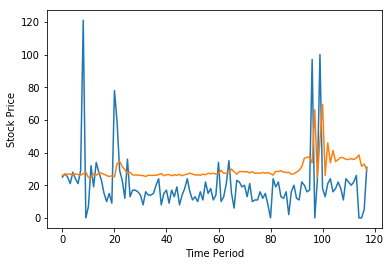

In [42]:
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY)
    rmse_val = sess.run(rmse, feed_dict={targets: denormalizedTestY_feed, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [43]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [44]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

20.364860324472062

In [45]:
rootMeanSquaredError(denormalizedTestY_preprocessed,denormalizedTestPredictY)

18.449244391207795

In [46]:
121 in denormalizedTestY

True

In [47]:
denormalizedTestY_preprocessed

[25,
 27,
 25,
 21,
 28,
 24,
 21,
 29,
 35,
 0,
 7,
 32,
 19,
 34,
 28,
 23,
 15,
 10,
 15,
 9,
 78,
 59,
 29,
 23,
 12,
 36,
 13,
 17,
 17,
 16,
 14,
 8,
 16,
 14,
 14,
 15,
 20,
 24,
 8,
 15,
 17,
 9,
 17,
 13,
 19,
 8,
 14,
 18,
 24,
 16,
 11,
 13,
 10,
 16,
 11,
 22,
 15,
 18,
 11,
 14,
 34,
 10,
 13,
 21,
 35,
 15,
 6,
 23,
 22,
 19,
 20,
 13,
 21,
 10,
 11,
 11,
 16,
 12,
 15,
 8,
 0,
 24,
 19,
 22,
 13,
 12,
 16,
 2,
 16,
 20,
 12,
 11,
 22,
 20,
 16,
 17,
 97,
 0,
 23,
 100,
 18,
 13,
 21,
 24,
 16,
 18,
 22,
 18,
 11,
 24,
 22,
 20,
 22,
 26,
 0,
 0,
 5,
 31]